# tensorflow transformer 모델로 한국어 심리상담 챗봇 구현

## 한국어 문장 형태소 분석

In [1]:
# Prerequisites

import logging
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_text

C:\Users\user\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 사용 데이터셋: 웰니스 대화 스크립트 데이터셋(AI Hub, 2019)
### 참고문헌: Translate Text with Transformer Models (Tensorflow, 2022)

[https://www.tensorflow.org/text/tutorials/transformer](https://www.tensorflow.org/text/tutorials/transformer)

In [2]:
#심리상담 웰니스 대화 스크립트 데이터셋을 불러옵니다.

df = pd.read_csv('all_wellness.csv')

In [4]:
print(df.shape)
print('-' * 20)
print(df.isnull().sum())
print('-' * 20)
df.head()

(22595, 3)
--------------------
question     0
response     0
embedding    0
dtype: int64
--------------------


,question,response,embedding
0,제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.,감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.,"[-0.4806065, -0.2948689, 0.43790027, -0.640137..."
1,더 이상 내 감정을 내가 컨트롤 못 하겠어.,감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.,"[-1.1561574, -0.14506218, 0.29490322, -0.67394..."
2,하루종일 오르락내리락 롤러코스터 타는 기분이에요.,저도 그 기분 이해해요. 많이 힘드시죠?,"[-0.66520023, -0.08126819, 1.0945566, 0.105791..."
3,꼭 롤러코스터 타는 것 같아요.,감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.,"[-0.2100391, 0.03955202, 1.0184706, -0.0718505..."
4,롤러코스터 타는 것처럼 기분이 왔다 갔다 해요.,저도 그 기분 이해해요. 많이 힘드시죠?,"[-0.43239346, -0.2468669, 0.9410948, -0.398536..."


<img src = '1.png'>

In [17]:
# 한국어 형태소 분석기 Mecab을 정의합니다.

from eunjeon import Mecab
import re

m = Mecab()

def reg_kor(sentence):
    
    # 한국어, 숫자, 지정한 특수문자를 제외한 html 언어를 제거합니다.
    sentence = re.sub('[^0-9가-힣!?,.()]', ' ', sentence)
    
    # 문장 양옆의 빈칸을 제거하고, 특수문자를 한 칸씩 띄어씁니다.
    sentence = re.sub(r"([,.?!])", r" \1", sentence.strip())
    
    # 두 칸 이상 벌어진 문자가 있으면 한 칸으로 통일해줍니다.
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # 한국어 형태소 분석기 mecab으로 형태소 분석을 진행합니다.
    sentence = " ".join(m.morphs(sentence))
    
    return sentence

In [18]:
# 질문 문장데이터 array에 할당

src_raw = np.array([reg_kor(df['question'][_]) for _ in range(len(df))])

In [19]:
# 전처리 전 질문 문장

for k, v in enumerate(df['question'][1000: 1005]):
    print(f'# {k} : {v}')

# 0 : 그 외 시간에는 늘 우울한 기분이 깔려 있어.
# 1 : 2년전부터 많이 우울했어요.
# 2 : 바쁠 땐 아무 생각이 없는데 한가해질 때면 우울함이 밀려와요.
# 3 : 대학 졸업하고 우울한 기분이 들 때도 있었지만 '인생이 다 그렇지 뭐'라고 대수롭지 않게 여겼어.
# 4 : 우울함은 돈으로 해결되는 부분이 아니니까요.


In [20]:
# 질문 문장 예시

for k, v in enumerate(src_raw[1000: 1005]):
    print(f'# {k} : {v}')

# 0 : 그 외 시간 에 는 늘 우울 한 기분 이 깔려 있 어 .
# 1 : 2 년 전 부터 많이 우울 했 어요 .
# 2 : 바쁠 땐 아무 생각 이 없 는데 한가 해질 때 면 우울 함 이 밀려 와요 .
# 3 : 대학 졸업 하 고 우울 한 기분 이 들 때 도 있 었 지만 인생 이 다 그렇 지 뭐 라고 대수 롭 지 않 게 여겼 어 .
# 4 : 우울 함 은 돈 으로 해결 되 는 부분 이 아니 니까요 .


In [21]:
# 답변 문장데이터 array에 할당

tgt_raw = np.array([reg_kor(df['response'][_]) for _ in range(len(df))])

In [22]:
# 전처리 전 답변 문장

for k, v in enumerate(df['response'][1000: 1005]):
    print(f'# {k} : {v}')

# 0 : 아무 이유 없이 우울할 때가 있죠.
# 1 : 우울할 때는 칭찬타임! 오늘의 잘한 일을 말해봐요.
# 2 : 그럴 때는 전문가에게 도움을 요청하는 것도 좋은 방법이에요.
# 3 : 우울할 때는 칭찬타임! 오늘의 잘한 일을 말해봐요.
# 4 : 그럴 때는 전문가에게 도움을 요청하는 것도 좋은 방법이에요.


In [23]:
# 답변 문장 예시

for k, v in enumerate(tgt_raw[1000: 1005]):
    print(f'# {k} : {v}')

# 0 : 아무 이유 없이 우울 할 때 가 있 죠 .
# 1 : 우울 할 때 는 칭찬 타임 ! 오늘 의 잘 한 일 을 말 해 봐요 .
# 2 : 그럴 때 는 전문가 에게 도움 을 요청 하 는 것 도 좋 은 방법 이 에요 .
# 3 : 우울 할 때 는 칭찬 타임 ! 오늘 의 잘 한 일 을 말 해 봐요 .
# 4 : 그럴 때 는 전문가 에게 도움 을 요청 하 는 것 도 좋 은 방법 이 에요 .


## Input & Output Embeddings

<img src = '2.png'>

In [24]:
# 토큰화 하기 전 SOS, EOS 토큰들을 정의합니다.

def sos_eos_tokenize(sentence):
    sentence = tf.strings.join(['[START]', sentence, '[END]'], separator = ' ')
    return sentence

In [26]:
# train, validation 자료들을 랜덤하게 나눕니다.
# train : validation = approximately 0.8 : 0.2

bf_size = len(src_raw)

rnd = np.random.uniform(size = (len(src_raw), )) < 0.8

train_raw = (tf.data.Dataset
             .from_tensor_slices((src_raw[rnd], tgt_raw[rnd]))
             .shuffle(bf_size))

validation_raw = (tf.data.Dataset
             .from_tensor_slices((src_raw[~rnd], tgt_raw[~rnd]))
             .shuffle(bf_size))

In [27]:
# 형태소 분석한 한국어 단어들을 토큰화 합니다.
# max_vocab_size = 10,000

max_vocab_size = 10000

src_text_processor = tf.keras.layers.TextVectorization(standardize = sos_eos_tokenize,
                                                      max_tokens = max_vocab_size,
                                                      ragged = True)

tgt_text_processor = tf.keras.layers.TextVectorization(standardize = sos_eos_tokenize,
                                                      max_tokens = max_vocab_size,
                                                      ragged = True)

src_text_processor.adapt(train_raw.map(lambda src, tgt: src))
tgt_text_processor.adapt(train_raw.map(lambda src, tgt: tgt))

In [31]:
for k, v in enumerate(src_text_processor.get_vocabulary()[0:10]):
    print(f'# {k} : {v}')

# 0 : 
# 1 : [UNK]
# 2 : [START]
# 3 : [END]
# 4 : .
# 5 : 이
# 6 : 는
# 7 : 하
# 8 : 고
# 9 : 가


In [29]:
for k, v in enumerate(tgt_text_processor.get_vocabulary()[:10]):
    print(f'# {k} : {v}')

# 0 : 
# 1 : [UNK]
# 2 : [START]
# 3 : [END]
# 4 : .
# 5 : 이
# 6 : 을
# 7 : 는
# 8 : 하
# 9 : 어요


In [35]:
# train 데이터, validation 데이터의 크기

print(len(train_raw))
print(len(validation_raw))
print(f'% of train data : {len(train_raw)/len(tgt_raw)*100:.2f}%')

18202
4393
% of train data : 80.56%


In [49]:
src_raw[0]

'제 감정 이 이상 해진 것 같 아요 . 남편 만 보 면 화 가 치밀 어 오르 고 감정 조절 이 안 되 요 .'

In [50]:
tokenized = src_text_processor(src_raw[0])
tokenized

<tf.Tensor: shape=(28,), dtype=int64, numpy=
array([   2,  102,  226,    5,  153,  897,   26,   16,   67,    4,  108,
         41,   55,   37,  200,    9, 1169,   10, 1128,    8,  226,  553,
          5,   20,   47,  173,    4,    3], dtype=int64)>

In [51]:
src_vocab = np.array(src_text_processor.get_vocabulary())
strings = src_vocab[tokenized.numpy()]
' '.join(strings)

'[START] 제 감정 이 이상 해진 것 같 아요 . 남편 만 보 면 화 가 치밀 어 오르 고 감정 조절 이 안 되 요 . [END]'

In [46]:
tgt_raw[0]

'감정 이 조절 이 안 될 때 만큼 힘들 때 는 없 는 거 같 아요 .'

In [47]:
tokenized = tgt_text_processor(tgt_raw[0])
tokenized

<tf.Tensor: shape=(19,), dtype=int64, numpy=
array([  2, 247,   5, 736,   5,  85, 167,  65, 113,  64,  65,   7,  51,
         7,  15,  31,  29,   4,   3], dtype=int64)>

In [48]:
tgt_vocab = np.array(tgt_text_processor.get_vocabulary())
strings = tgt_vocab[tokenized.numpy()]
' '.join(strings)

'[START] 감정 이 조절 이 안 될 때 만큼 힘들 때 는 없 는 거 같 아요 . [END]'

In [58]:
plt.rcParams['font.family'] = 'NanumGothic'

### 데이터 임베딩 결과

Text(0.5, 1.0, 'zero-padding 결과')

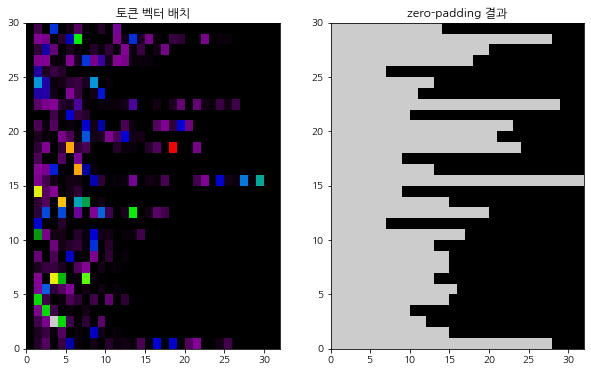

In [65]:
zp = src_text_processor(src_raw[:30])
plt.figure(figsize = (10, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(zp.to_tensor(), cmap = 'nipy_spectral')
plt.title('토큰 벡터 배치')

plt.subplot(1, 2, 2)
plt.pcolormesh(zp.to_tensor() != 0, cmap = 'nipy_spectral')
plt.title('zero-padding 결과')

In [66]:
# Train, Validation 데이터셋을 zero-padded 토큰으로 변화합니다.
# Transformer 모델에 사용하기 위해 한 단어의 텀을 가진 tgt_inputs, tgt_labels 변수를 분리하고,
# tgt_in 변수와 src 변수를 묶어줍니다.

MAX_TOKENS = 128

def prepare_batch(src, tgt):
    src = src_text_processor(src)
    src = src[:, :MAX_TOKENS]
    src = src.to_tensor()
    
    tgt = tgt_text_processor(tgt)
    tgt = tgt[:, :(MAX_TOKENS + 1)]
    tgt_inputs = tgt[:, :-1].to_tensor() # Drop [END] tokens
    tgt_labels = tgt[:, 1:].to_tensor() # Drop [start] tokens

    return (src, tgt_inputs), tgt_labels

In [67]:
# buffer_size : 20,000 크기의 buffer에 담은 후 변수들을 shuffle합니다.
# batch_size : 배치 사이즈 = 64

BUFFER_SIZE = 20000
BATCH_SIZE = 64

def make_batches(ds):
    return (
        ds.shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .map(prepare_batch, tf.data.AUTOTUNE)
        .prefetch(buffer_size=tf.data.AUTOTUNE))

In [68]:
# Train과 Validation batches 만들기

train_batches = make_batches(train_raw)
val_batches = make_batches(validation_raw)

In [69]:
for (q, a), a_labels in train_batches.take(1):
    break

print(q.shape)
print(a.shape)
print(a_labels.shape)

(64, 34)
(64, 29)
(64, 29)


In [70]:
print(a[0][:10])
print(a_labels[0][:10])

tf.Tensor([   2   99   55    6   69   26    8    7   77 2103], shape=(10,), dtype=int64)
tf.Tensor([  99   55    6   69   26    8    7   77 2103    8], shape=(10,), dtype=int64)


In [22]:
# Q, K, V 데이터를 정의했기에
# 불필요한 데이터는 삭제합니다.

del df
del src_raw; del tgt_raw
del train_raw
del validation_raw

## Positional Encoding

<img src = 'https://www.tensorflow.org/images/tutorials/transformer/PositionalEmbedding.png'>

사진출처: [https://www.tensorflow.org/text/tutorials/transformer](https://www.tensorflow.org/text/tutorials/transformer)

<img src = '4.png'>

In [81]:
#length = sentence에 존재할 수 있는 maximum amount of tokens (length = 2048)
#depth = dimension of th emodel (d_model = 512)
# i = ~ depth/2 = [0, ..., 255]

def positional_encoding(length, depth):
    # d_model/2
    depth = depth/2

    # pos = 토큰의 위치 [0, ..., 2047]
    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    # i / (d_model/2) = 2i/d_model 
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
      
    # 1/10000^(2i/d_model)
    angle_rates = 1 / (10000**depths)         # (1, depth)
    # pos/(10000)^(2i/d_model)
    angle_rads = positions * angle_rates      # (pos, depth)
    
    #[sin(0), cos(0)], [sin(2), cos(2)].... 
    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis = -1) 
    
    # encoding한 값을 float으로 반환합니다.
    return tf.cast(pos_encoding, dtype = tf.float32)

In [82]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(length = 2048, depth = d_model)

    # embedding할 때, 길이를 맞추어주기 위해 padding 목적으로 넣은 zero-padded된 단어를 표시합니다.
    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    # 호출 시
    def call(self, x):
        # 2048
        length = tf.shape(x)[1]
        # 앞서 정의한 float로 반환한 x (PE_pos)
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))      
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        
        return x

In [83]:
# positional encoding을 진행한 후 embedding을 완료합니다.

embed_kr = PositionalEmbedding(vocab_size = src_text_processor.vocabulary_size(), d_model = 512)
embed_en = PositionalEmbedding(vocab_size = tgt_text_processor.vocabulary_size(), d_model = 512)

q_emb = embed_kr(q)
a_emb = embed_en(a)

## Base Attention Layer

<img src = 'https://www.tensorflow.org/images/tutorials/transformer/BaseAttention.png' width = '400' align = 'left'>

사진출처: [https://www.tensorflow.org/text/tutorials/transformer](https://www.tensorflow.org/text/tutorials/transformer)

<img src = '5.png'>

In [27]:
# attention layer에 상속할 base attention layer을 정의합니다.

class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        # Define multihead attention layer
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        
        # Define normalization layer =  LayerNorm()
        self.layernorm = tf.keras.layers.LayerNormalization()
        
        # Define addition layer = (x + sublayer(x))
        self.add = tf.keras.layers.Add()

## Cross Attention Layer

<img src = 'https://www.tensorflow.org/images/tutorials/transformer/CrossAttention.png' align = 'left' width = '400'>

사진출처: [https://www.tensorflow.org/text/tutorials/transformer](https://www.tensorflow.org/text/tutorials/transformer)

<img src = 6.png>

In [28]:
# Encoder의 결과값을 Decoder로 넘겨주는 attention layer입니다.
# BaseAttention의 클래스를 상속합니다.

class CrossAttention(BaseAttention):
    # self-attention layer에서 x를, encoder에서 key, value를 받아옵니다.
    def call(self, x, context):
        attn_output, attn_scores = self.mha(query = x,
                                            key = context,
                                            value = context,
                                            return_attention_scores = True)
   
        self.last_attn_scores = attn_scores

        # Output (x) = LayerNorm(x + sublayer(x))
        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

## Global Self-Attention Layer

<img src = 'https://www.tensorflow.org/images/tutorials/transformer/SelfAttention.png' align = 'left' width = '400'>
<img src = 'https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention.png' width = '400'>

사진출처: [https://www.tensorflow.org/text/tutorials/transformer](https://www.tensorflow.org/text/tutorials/transformer)

<img src = '7.png'>

In [30]:
class GlobalSelfAttention(BaseAttention):
    # Encoder, Decoder 각각에서 Query, Value, Key 값을 가져옵니다.
    def call(self, x):
        attn_output = self.mha(query = x,
                               value = x,
                               key = x)
        
        # Output (x) = LayerNorm(x + sublayer(x))
        x = self.add([x, attn_output])
        x = self.layernorm(x)
    
        return x

## Casual Self Attention Layer

In [32]:
class CausalSelfAttention(BaseAttention):
    # Encoder, Decoder 각각에서 Query, Value, Key 값을 가져옵니다.
    def call(self, x):
        attn_output = self.mha(query = x,
                               value = x,
                               key = x,
                               use_causal_mask = True)
        
        # Output (x) = LayerNorm(x + sublayer(x))
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        
        return x

## Feed Forward Layer

<img src = 'https://www.tensorflow.org/images/tutorials/transformer/FeedForward.png' width = '400' align = 'left'>

사진출처: [https://www.tensorflow.org/text/tutorials/transformer](https://www.tensorflow.org/text/tutorials/transformer)

<img src = '8.png'>

In [34]:
# one-layer feedforward layer
# dff (2048) -> d_model (512)

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            # 2048, relu
            tf.keras.layers.Dense(dff, activation='relu'),
            # 2048 -> 512
            tf.keras.layers.Dense(d_model),
            # 0.1만큼 overfitting 방지
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        # Output (x) = LayerNorm(x + sublayer(x))
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

## Encoder Layer

<img src = 'https://www.tensorflow.org/images/tutorials/transformer/EncoderLayer.png' width = '450' align = 'left'>

사진출처: [https://www.tensorflow.org/text/tutorials/transformer](https://www.tensorflow.org/text/tutorials/transformer)

<img src = '9.png'>

In [36]:
# n_layer중 하나의 Encoder layer 층

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        
        # Encoder 층의 self-attention + Feed Forward 층을 정의합니다.
        self.self_attention = GlobalSelfAttention(
            num_heads = num_heads,
            key_dim = d_model,
            dropout = dropout_rate)
        
        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        
        return x

In [38]:
# n_layer의 연산을 전부 수행한 Encoder 모델

class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
                 dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        
        # 1. positional embedding 진행하기
        self.pos_embedding = PositionalEmbedding(
            vocab_size = vocab_size, d_model = d_model)
        
        self.enc_layers = [
            # 2. Encoder layer (self-attention, feed forward num_layer 번만큼 반복)
            EncoderLayer(d_model = d_model,
                         num_heads = num_heads,
                         dff = dff,
                         dropout_rate = dropout_rate)    
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.pos_embedding(x)
    
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x

## Decoder Layer

<img src = 'https://www.tensorflow.org/images/tutorials/transformer/DecoderLayer.png' width = '450' align = 'left'>

사진출처: [https://www.tensorflow.org/text/tutorials/transformer](https://www.tensorflow.org/text/tutorials/transformer)

<img src = '10.png'>

In [40]:
# n_layer중 하나의 Decoder layer 층

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads,
                 dff, dropout_rate = 0.1):
        super(DecoderLayer, self).__init__()

        # Decoder 층의 self-attention + cross_attention + Feed Forward 층을 정의합니다.
        self.causal_self_attention = CausalSelfAttention(
            num_heads = num_heads,
            key_dim = d_model,
            dropout = dropout_rate)
    
        self.cross_attention = CrossAttention(
            num_heads = num_heads,
            key_dim = d_model,
            dropout = dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x = x)
        x = self.cross_attention(x = x, context = context)

        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x) 
        
        return x

In [42]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
                 dff, vocab_size, dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        # 1. positional embedding 진행하기
        self.pos_embedding = PositionalEmbedding(vocab_size = vocab_size,
                                                 d_model = d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            # 2. Decoder layer (self-attention, cross-attention, feed forward num_layer 번만큼 반복)
            DecoderLayer(d_model = d_model, num_heads = num_heads,
                         dff = dff, dropout_rate = dropout_rate)
            for _ in range(num_layers)]

        self.last_attn_scores = None

    
    def call(self, x, context):
        x = self.pos_embedding(x) 

        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        return x

## Transformer

<img src = 'https://www.tensorflow.org/images/tutorials/transformer/transformer.png' width = '400' align = 'left'>

사진출처: [https://www.tensorflow.org/text/tutorials/transformer](https://www.tensorflow.org/text/tutorials/transformer)

<img src = '11.png'>

In [45]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,
                 input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        
        self.encoder = Encoder(num_layers = num_layers, d_model = d_model,
                               num_heads = num_heads, dff = dff,
                               vocab_size = input_vocab_size,
                               dropout_rate = dropout_rate)

        self.decoder = Decoder(num_layers = num_layers, d_model = d_model,
                               num_heads = num_heads, dff = dff,
                               vocab_size = target_vocab_size,
                               dropout_rate = dropout_rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    
    def call(self, inputs):
        context, x  = inputs
        context = self.encoder(context) 
        x = self.decoder(x, context) 
        

        logits = self.final_layer(x)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

## Hyperparameters

In [96]:
# num_layers = encoder, decoder 6번 반복:
# d_model = model 벡터의 dimension
# num_heads = attention 병렬 연산하는 횟수
# dff = model의 중간 학습 layer 크기

num_layers = 6
d_model = 512
dff = 512
num_heads = 8
dropout_rate = 0.1

## Transformer Model

In [97]:
transformer = Transformer(
    num_layers = num_layers,
    d_model = d_model,
    num_heads = num_heads,
    dff = dff,
    input_vocab_size = src_text_processor.vocabulary_size(),
    target_vocab_size = tgt_text_processor.vocabulary_size(),
    dropout_rate = dropout_rate)

In [100]:
# summary

transformer.summary()

Model: "transformer_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_3 (Encoder)         multiple                  4983808   
                                                                 
 decoder_3 (Decoder)         multiple                  7665024   
                                                                 
 dense_76 (Dense)            multiple                  544509    
                                                                 
Total params: 13,193,341
Trainable params: 13,193,341
Non-trainable params: 0
_________________________________________________________________


## Setting up optimized learning_rate

$${lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [101]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps = 4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

## Define Optimizers

In [102]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1 = 0.9, beta_2 = 0.98,
                                     epsilon = 1e-9)

Text(0.5, 0, 'Train_step')

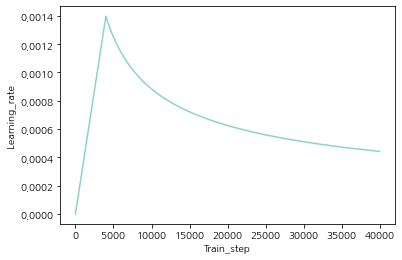

In [103]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning_rate')
plt.xlabel('Train_step')

In [104]:
# apply padding-mask when calculating a loss

def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

## Train model

<img src = '12.png'>

In [105]:
transformer.compile(
    loss = masked_loss,
    optimizer = optimizer,
    metrics = [masked_accuracy])

In [106]:
history = transformer.fit(train_batches,
                epochs = 20,
                validation_data = val_batches,
                callbacks=[
                    tf.keras.callbacks.EarlyStopping(patience = 3)])

Epoch 1/20
283/283 [==============================] - 655s 2s/step - loss: 7.3346 - masked_accuracy: 0.1156 - val_loss: 5.9918 - val_masked_accuracy: 0.1658
Epoch 2/20
283/283 [==============================] - 642s 2s/step - loss: 4.9195 - masked_accuracy: 0.2659 - val_loss: 3.8787 - val_masked_accuracy: 0.4090
Epoch 3/20
283/283 [==============================] - 638s 2s/step - loss: 3.3443 - masked_accuracy: 0.4457 - val_loss: 2.7864 - val_masked_accuracy: 0.5177
Epoch 4/20
283/283 [==============================] - 611s 2s/step - loss: 2.5466 - masked_accuracy: 0.5563 - val_loss: 2.2655 - val_masked_accuracy: 0.6079
Epoch 5/20
283/283 [==============================] - 629s 2s/step - loss: 2.1357 - masked_accuracy: 0.6174 - val_loss: 2.0331 - val_masked_accuracy: 0.6410
Epoch 6/20
283/283 [==============================] - 619s 2s/step - loss: 1.9130 - masked_accuracy: 0.6455 - val_loss: 1.9168 - val_masked_accuracy: 0.6528
Epoch 7/20
283/283 [==============================] - 620s

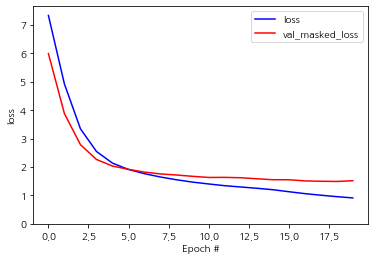

In [108]:
# 모델의 loss을 확인합니다.

plt.plot(history.history['loss'], label='loss', c = 'b')
plt.plot(history.history['val_loss'], label='val_masked_loss', c = 'r')

plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('loss')
plt.legend()

In [114]:
df_loss = pd.DataFrame({'loss' : history.history['loss'],
                       'val_loss' : history.history['val_loss']})
df_loss = df_loss.sort_values(by = 'val_loss').reset_index(drop = True)
df_loss.head()

,loss,val_loss
0,0.955903,1.491439
1,1.006782,1.497360
2,1.062898,1.511066
3,0.911044,1.516273
4,1.130434,1.551142


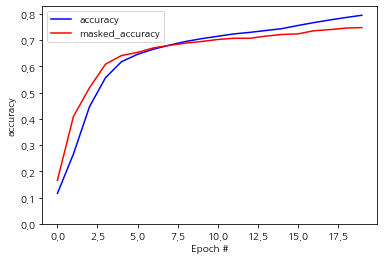

In [115]:
# 모델의 정확도를 확인합니다.

plt.plot(history.history['masked_accuracy'], label='accuracy', c = 'b')
plt.plot(history.history['val_masked_accuracy'], label='masked_accuracy', c = 'r')

plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('accuracy')
plt.legend()

In [118]:
df_acc = pd.DataFrame({'acc' : history.history['masked_accuracy'],
                       'val_acc' : history.history['val_masked_accuracy']})
df_acc = df_acc.sort_values(by = 'val_acc', ascending = False).reset_index(drop = True)
df_acc.head()

,acc,val_acc
0,0.794280,0.747361
1,0.785688,0.745479
2,0.776348,0.739526
3,0.766270,0.735167
4,0.755156,0.723194


## Predict new sentences

<img src = '15.png'>

In [903]:
tgt_vocab = tgt_text_processor.get_vocabulary()

tgt_index_to_word = {}
for index, word in enumerate(tgt_vocab):
    tgt_index_to_word[index] = word

In [1169]:
class Translator(tf.Module):
    def __init__(self, transformer, src_txt_processor, tgt_txt_processor):
        self.transformer = transformer
        self.src_txt_processor = src_txt_processor
        self.tgt_txt_processor = tgt_txt_processor

    def __call__(self, sentence, max_length = MAX_TOKENS):
        # The input sentence is Korean, hence adding the `[START]` and `[END]` tokens.
        assert isinstance(sentence, tf.Tensor)
        if len(sentence.shape) == 0:
            sentence = sentence[tf.newaxis]
            
        texts = tf.convert_to_tensor(sentence)
        sentence = self.src_txt_processor(texts).to_tensor()
    
        encoder_input = sentence

        # As the output language is English, initialize the output with the
        # English `[START]` token.
        start = [2]
        end = [3]

        # `tf.TensorArray` is required here (instead of a Python list), so that the
        # dynamic-loop can be traced by `tf.function`.
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size = True)
        output_array = output_array.write(0, start)
        
        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions = self.transformer([encoder_input, output], training = False)

            # Select the last token from the `seq_len` dimension.
            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

            predicted_id = tf.argmax(predictions, axis = -1)

            # Concatenate the `predicted_id` to the output which is given to the
            # decoder as its input.
            output_array = output_array.write(i+1, predicted_id[0])

            if predicted_id == end:
                break
        
        tgt_vocab = self.tgt_txt_processor.get_vocabulary()

        tgt_index_to_word = {}
        for index, word in enumerate(tgt_vocab):
            tgt_index_to_word[index] = word
    
        output = tf.transpose(output_array.stack())
        # The output shape is `(1, tokens)`
        text = " ".join([tgt_index_to_word.get(_) for _ in output[0].numpy()[1: -1]])
        tokens = output

        # `tf.function` prevents us from using the attention_weights that were
        # calculated on the last iteration of the loop.
        # So, recalculate them outside the loop.
        self.transformer([encoder_input, output[:,:-1]], training=False)
        attention_weights = self.transformer.decoder.last_attn_scores

        return text, tokens, attention_weights

In [1170]:
translator = Translator(transformer, src_text_processor, tgt_text_processor)

In [1180]:
def print_translation(sentence, tokens):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens}')

In [1214]:
inp = '도무지 해결 할 수 없는 일들이 마구잡이로 벌어지고 있어요.'
print('Q : ', inp)
print('-' * 20)
sentence = reg_kor(inp)
translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print('A : ', translated_text)

Q :  도무지 해결 할 수 없는 일들이 마구잡이로 벌어지고 있어요.
--------------------
A :  그런 일 이 있 으셨 군요 .


In [1216]:
inp = '어제 여자친구랑 헤어졌어요.'
print('Q : ', inp)
print('-' * 20)
sentence = reg_kor(inp)
translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print('A : ', translated_text)

Q :  어제 여자친구랑 헤어졌어요.
--------------------
A :  마음 이 복잡 하 겠 어요 .


In [1217]:
inp = '몸이 아파서 제대로 생활하지 못하겠어요.'
print('Q : ', inp)
print('-' * 20)
sentence = reg_kor(inp)
translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print('A : ', translated_text)

Q :  몸이 아파서 제대로 생활하지 못하겠어요.
--------------------
A :  저 는 당신 이 있 어 행복 한데 그런 당신 도 행복 했 으면 좋 겠 어요 .


In [1221]:
inp = '죽을 것 같이 힘들어요.'
print('Q : ', inp)
print('-' * 20)
sentence = reg_kor(inp)
translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print('A : ', translated_text)

Q :  죽을 것 같이 힘들어요.
--------------------
A :  꼭 전화 하 셔서 도움 을 받 으시 길 바라 요 . [ 24 시간 전화 상담 ] 희망 의 전화 129 청소년 전화 1388 자살 예방 핫라인 1577 - 0199 생명 의 전화 1588 - 9191 사랑 의 전화 상담 센터 1566 - 2525


In [1228]:
inp = '특별히 잘하는 것이 없는 제가 싫어요.'
print('Q : ', inp)
print('-' * 20)
sentence = reg_kor(inp)
translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print('A : ', translated_text)

Q :  특별히 잘하는 것이 없는 제가 싫어요.
--------------------
A :  마음 이 복잡 하 겠 어요 .


In [1229]:
inp = '다른 사람 말에 지나치게 민감해요.'
print('Q : ', inp)
print('-' * 20)
sentence = reg_kor(inp)
translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print('A : ', translated_text)

Q :  다른 사람 말에 지나치게 민감해요.
--------------------
A :  갑자기 숨 이 잘 안 쉬 어 지 면 정말 힘들 것 같 아요 . 지금 은 괜찮 으신 가요 ?


# Attention Plots

In [136]:
def plot_attention_head(in_tokens, translated_tokens, attention):
    # The model didn't generate `<START>` in the output. Skip it.
    translated_tokens = translated_tokens.reshape(-1)[1:]
    
    ax = plt.gca()
    ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(translated_tokens)))

    labels = [src_index_to_word.get(_) for _ in in_tokens.numpy()]
    ax.set_xticklabels(labels, rotation=90)

    labels = [tgt_index_to_word.get(_) for _  in translated_tokens]
    ax.set_yticklabels(labels)

In [137]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([16, 14])

In [139]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
    in_tokens = tf.convert_to_tensor(sentence)
    in_tokens = src_text_processor(in_tokens)

    fig = plt.figure(figsize=(12, 24))

    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(4, 2, h+1)

        plot_attention_head(in_tokens, translated_tokens, head)

        ax.set_xlabel(f'Head {h+1}')

    plt.tight_layout()
    plt.show()

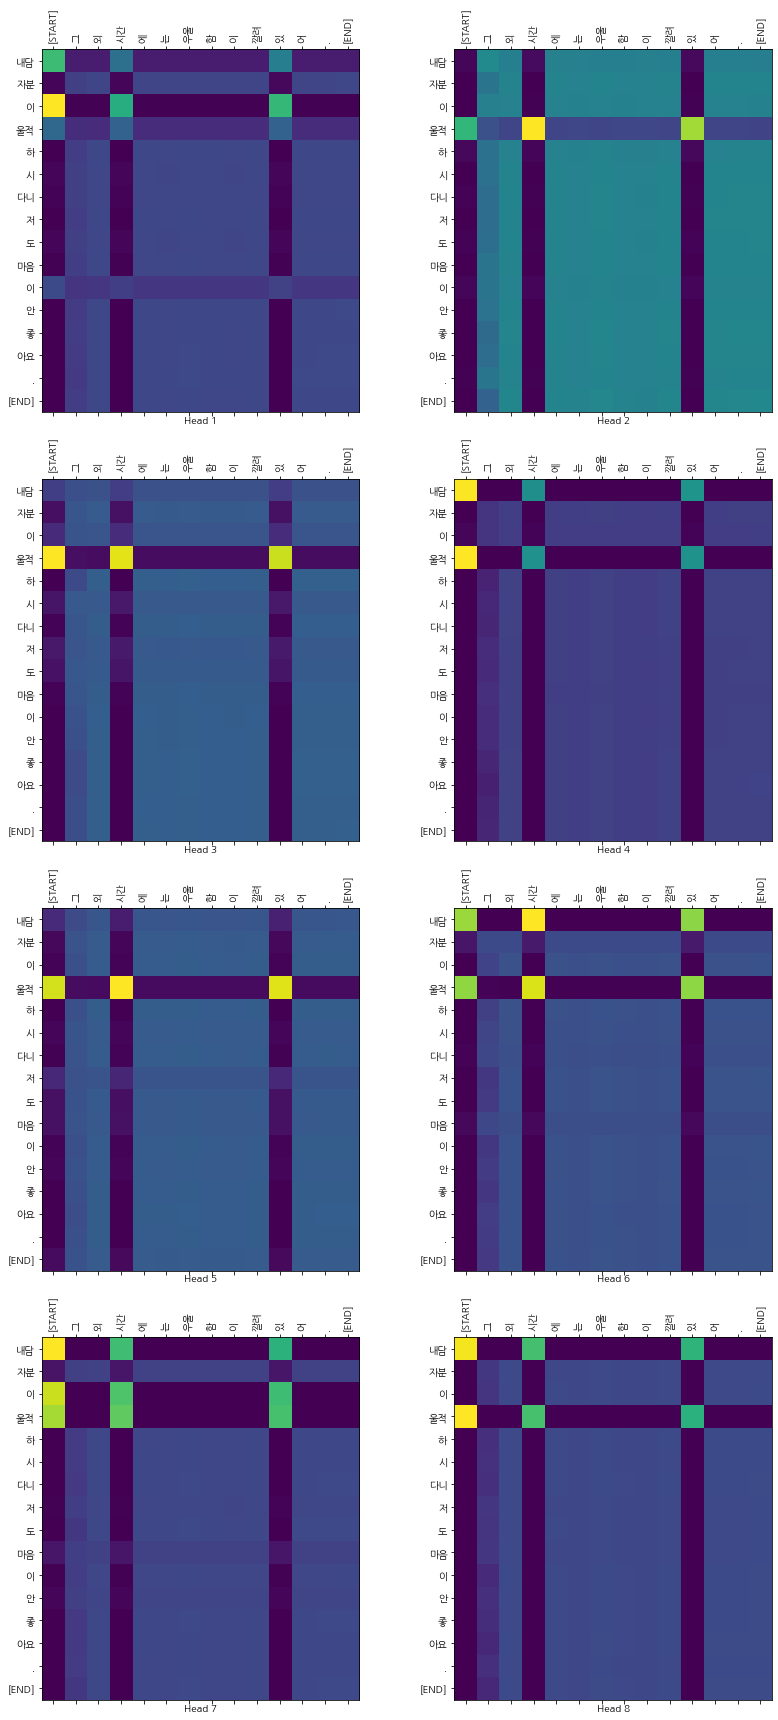

In [140]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])